In [28]:
import sys
import os
import subprocess

app_base_dir = '/home/eusobg/EUSO-SPB/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import collections
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
#import ROOT

In [29]:
import tool.npy_frames_visualization as npy_vis


In [30]:
con = pg.connect("dbname=eusospb_data user=eusospb password=1e20eVjemeuso host=localhost")
cur = con.cursor()

# Number of packets

In [31]:
t_all_bgf05_simu_events_by_energy_query = \
'''
SELECT COUNT(sq.count_event_id) AS count_packets, sq.etruth_trueenergy AS etruth_trueenergy 
FROM (
  SELECT COUNT(dt1.event_id) AS count_event_id, dt1.source_file_acquisition_full, etruth_trueenergy 
  FROM simu_event_spb_proc 
  JOIN simu_event USING(simu_event_id) 
  JOIN spb_processing_event_ver2 AS dt1 USING(event_id) 
  JOIN spb_processing_event_ver2 AS dt2 USING(source_file_acquisition_full) 
  WHERE dt1.source_data_type_num=3 AND dt2.source_data_type_num=5
  GROUP BY etruth_trueenergy, dt1.source_file_acquisition_full, dt1.packet_id
) as sq GROUP BY etruth_trueenergy ORDER BY etruth_trueenergy;
'''

t_all_bgf05_simu_events_by_energy = psql.read_sql( t_all_bgf05_simu_events_by_energy_query   ,con)

In [32]:
t_all_bgf05_simu_events_by_energy

,count_packets,etruth_trueenergy
0,1,1.412540e+12
1,2,1.900000e+12
2,1,1.995260e+12
3,1,2.100000e+12
4,2,2.238720e+12
5,2,2.300000e+12
6,5,2.350000e+12
7,3,2.400000e+12
8,2,2.420000e+12
9,1,2.500000e+12


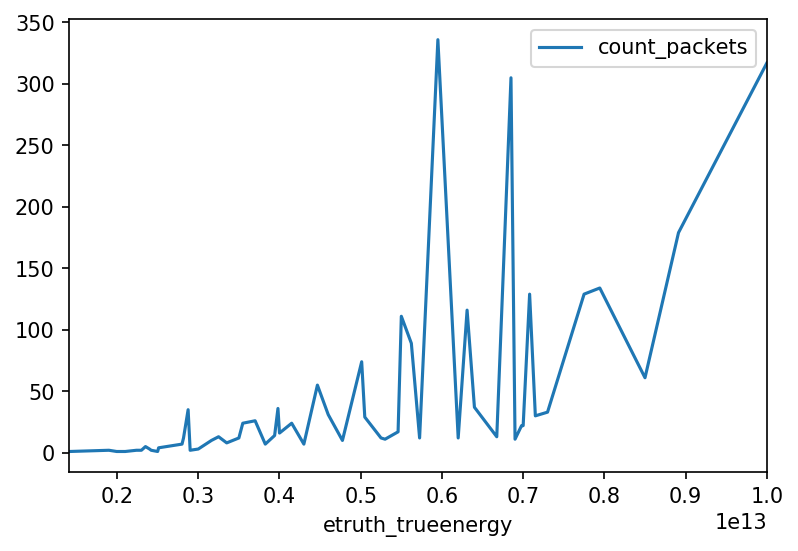

In [33]:
t_all_bgf05_simu_events_by_energy.plot(x='etruth_trueenergy', y='count_packets')
plt.show()

In [34]:
#AND x_y_hough__peak_thr3__avg_line_coord_0_x > 8 AND x_y_hough__peak_thr3__avg_line_coord_0_y > 8
cond_selection_rules = '''
  AND x_y_active_pixels_num > 1750
  AND num_gtu BETWEEN 11 AND 40
  AND num_triggered_pixels >= 6
  AND (abs(gtu_y_hough__peak_thr2_avg_phi) > 0.174533 OR abs(gtu_x_hough__peak_thr2_avg_phi) > 0.174533)
  AND num_triggered_pixels < 150
  AND trigg_x_y_hough__peak_thr1__max_cluster_counts_sum_width < 20
  AND trigg_gtu_x_hough__peak_thr1__max_cluster_counts_sum_width < 41 AND trigg_gtu_y_hough__peak_thr1__max_cluster_counts_sum_width < 41
  AND x_y_hough__peak_thr1__max_cluster_counts_sum_width < 25
  AND trigg_gtu_y_hough__peak_thr2__max_cluster_counts_sum_width < 20 AND trigg_gtu_y_hough__peak_thr2__max_cluster_counts_sum_height < 20
  AND trigg_gtu_x_hough__peak_thr2__max_cluster_counts_sum_width < 20 AND trigg_gtu_x_hough__peak_thr2__max_cluster_counts_sum_height < 20
  AND gtu_y_hough__dbscan_num_clusters_above_thr1 < 4 AND gtu_x_hough__dbscan_num_clusters_above_thr1 < 4
  AND trigg_x_y_hough__dbscan_num_clusters_above_thr1 < 4
  AND ( abs(gtu_y_hough__peak_thr3_avg_phi) NOT BETWEEN 1.48353 AND 1.65806  OR  abs(gtu_x_hough__peak_thr3_avg_phi) NOT BETWEEN 1.48353 AND 1.65806 )
  AND trigg_gtu_y_hough__dbscan_num_clusters_above_thr1 < 4 AND trigg_gtu_x_hough__dbscan_num_clusters_above_thr1 < 4
  AND gtu_y_hough__peak_thr1__max_cluster_counts_sum_width < 41 AND gtu_x_hough__peak_thr1__max_cluster_counts_sum_width < 41
'''

In [35]:
 # IMPORTANT
t_cond_bgf05_simu_events_by_energy_query = \
'''
SELECT COUNT(sq.count_event_id) AS count_packets, sq.etruth_trueenergy AS etruth_trueenergy 
 FROM (
  SELECT COUNT(dt1.event_id) AS count_event_id, dt1.source_file_acquisition_full, etruth_trueenergy 
  FROM simu_event_spb_proc 
  JOIN simu_event USING(simu_event_id) 
  JOIN (
   SELECT event_id, source_file_acquisition_full, packet_id
   FROM spb_processing_event_ver2
   WHERE
   source_data_type_num=3  
   {cond_selection_rules}
  ) AS dt1 USING(event_id) 
  JOIN spb_processing_event_ver2 AS dt2 USING(source_file_acquisition_full) 
  WHERE dt2.source_data_type_num=5
  GROUP BY etruth_trueenergy, dt1.source_file_acquisition_full, dt1.packet_id) AS sq 
 GROUP BY etruth_trueenergy ORDER BY etruth_trueenergy;
'''.format(cond_selection_rules=cond_selection_rules)

t_cond_bgf05_simu_events_by_energy = psql.read_sql(t_cond_bgf05_simu_events_by_energy_query, con)

In [36]:
t_cond_bgf05_simu_events_by_energy

,count_packets,etruth_trueenergy
0,1,1.412540e+12
1,1,1.900000e+12
2,1,1.995260e+12
3,1,2.100000e+12
4,2,2.238720e+12
5,2,2.300000e+12
6,2,2.350000e+12
7,2,2.420000e+12
8,1,2.500000e+12
9,4,2.511890e+12


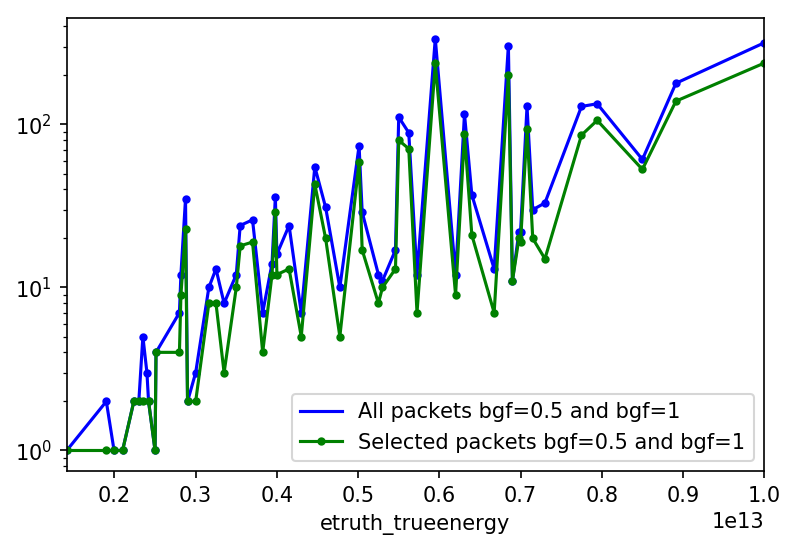

In [37]:
ax_t_all_bgf05_simu_events_by_energy = t_all_bgf05_simu_events_by_energy.plot(x='etruth_trueenergy',y='count_packets',marker='.',linestyle='-', color='blue', label="All packets bgf=0.5 and bgf=1")
#all_bgf10_simu_events_by_energy.plot(x='etruth_trueenergy',y='count_packets',marker='.',linestyle='-', color='red', ax=ax_all_simu_events_by_energy)
t_cond_bgf05_simu_events_by_energy.plot(x='etruth_trueenergy',y='count_packets',marker='.',linestyle='-', color='green', ax=ax_t_all_bgf05_simu_events_by_energy, label="Selected packets bgf=0.5 and bgf=1")
ax_t_all_bgf05_simu_events_by_energy.set_yscale("log", nonposy='clip')
plt.show()

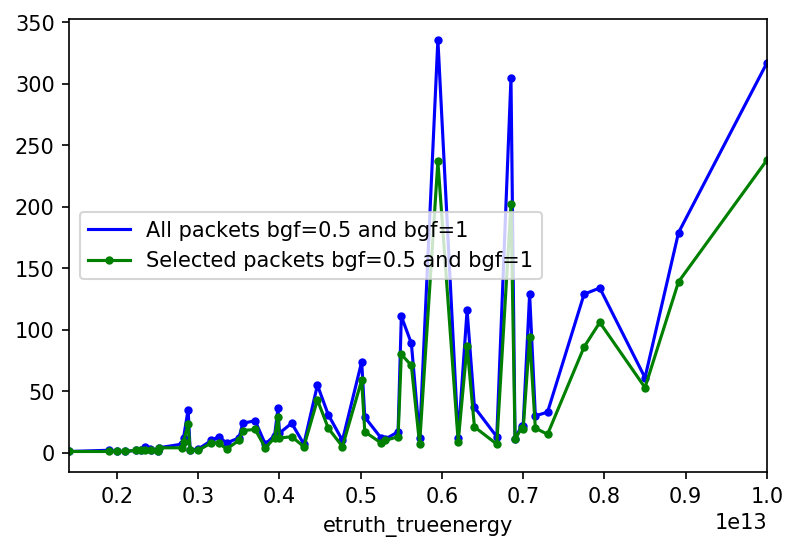

In [38]:
ax_t_all_bgf05_simu_events_by_energy = t_all_bgf05_simu_events_by_energy.plot(x='etruth_trueenergy',y='count_packets',marker='.',linestyle='-', color='blue', label="All packets bgf=0.5 and bgf=1")
#all_bgf10_simu_events_by_energy.plot(x='etruth_trueenergy',y='count_packets',marker='.',linestyle='-', color='red', ax=ax_all_simu_events_by_energy)
t_cond_bgf05_simu_events_by_energy.plot(x='etruth_trueenergy',y='count_packets',marker='.',linestyle='-', color='green', ax=ax_t_all_bgf05_simu_events_by_energy, label="Selected packets bgf=0.5 and bgf=1")
# ax_t_all_bgf05_simu_events_by_energy.set_yscale("log", nonposy='clip')
plt.show()

In [41]:
t_cond_bgf05_simu_events_by_energy_merged = pd.merge(t_cond_bgf05_simu_events_by_energy, t_all_bgf05_simu_events_by_energy,
                                    how='outer',
                                    suffixes=['_cond','_all'],
                                    on=['etruth_trueenergy'])
t_cond_bgf05_simu_events_by_energy_merged_nona = t_cond_bgf05_simu_events_by_energy_merged.dropna().copy()
t_cond_bgf05_simu_events_by_energy_merged_nona['count_fraction'] = t_cond_bgf05_simu_events_by_energy_merged_nona['count_packets_cond'] / t_cond_bgf05_simu_events_by_energy_merged_nona['count_packets_all']
t_cond_bgf05_simu_events_by_energy_merged_nona

,count_packets_cond,etruth_trueenergy,count_packets_all,count_fraction
0,1.0,1.412540e+12,1,1.000000
1,1.0,1.900000e+12,2,0.500000
2,1.0,1.995260e+12,1,1.000000
3,1.0,2.100000e+12,1,1.000000
4,2.0,2.238720e+12,2,1.000000
5,2.0,2.300000e+12,2,1.000000
6,2.0,2.350000e+12,5,0.400000
7,2.0,2.420000e+12,2,1.000000
8,1.0,2.500000e+12,1,1.000000
9,4.0,2.511890e+12,4,1.000000


In [42]:
n1 = t_cond_bgf05_simu_events_by_energy_merged_nona['count_packets_cond']
n2 = t_cond_bgf05_simu_events_by_energy_merged_nona['count_packets_all']

yerrs = list( np.sqrt( ((1-(n1/n2))/n1) + (1/n2) ) * t_cond_bgf05_simu_events_by_energy_merged_nona['count_fraction'] ) 
#yerrs = list( np.sqrt(n1 * (1 - n1/n2))/n2 )
yerrs


[1.0,
 0.5,
 1.0,
 1.0,
 0.70710678118654757,
 0.70710678118654757,
 0.28284271247461906,
 0.70710678118654757,
 1.0,
 0.5,
 0.2857142857142857,
 0.25,
 0.13702375780893486,
 0.70710678118654757,
 0.47140452079103168,
 0.28284271247461906,
 0.2175713172881685,
 0.2165063509461097,
 0.26352313834736496,
 0.17677669529663687,
 0.16764995936694899,
 0.2857142857142857,
 0.24743582965269673,
 0.14958791130929178,
 0.21650635094610965,
 0.15023130314433289,
 0.31943828249996997,
 0.11922615498730911,
 0.14426245016127676,
 0.22360679774997896,
 0.10379926686308928,
 0.14217605605578137,
 0.23570226039551584,
 0.28747978728803447,
 0.21209125149788172,
 0.080579026216208632,
 0.094675840148048973,
 0.22047927592204922,
 0.045817869995061468,
 0.25,
 0.080408440112834614,
 0.12385339716096865,
 0.2035193316203531,
 0.046598919355907847,
 0.30151134457776363,
 0.20327890704543541,
 0.19813177016093972,
 0.075157827246764786,
 0.14907119849998596,
 0.11736313170325505,
 0.071888515468958941,
 0

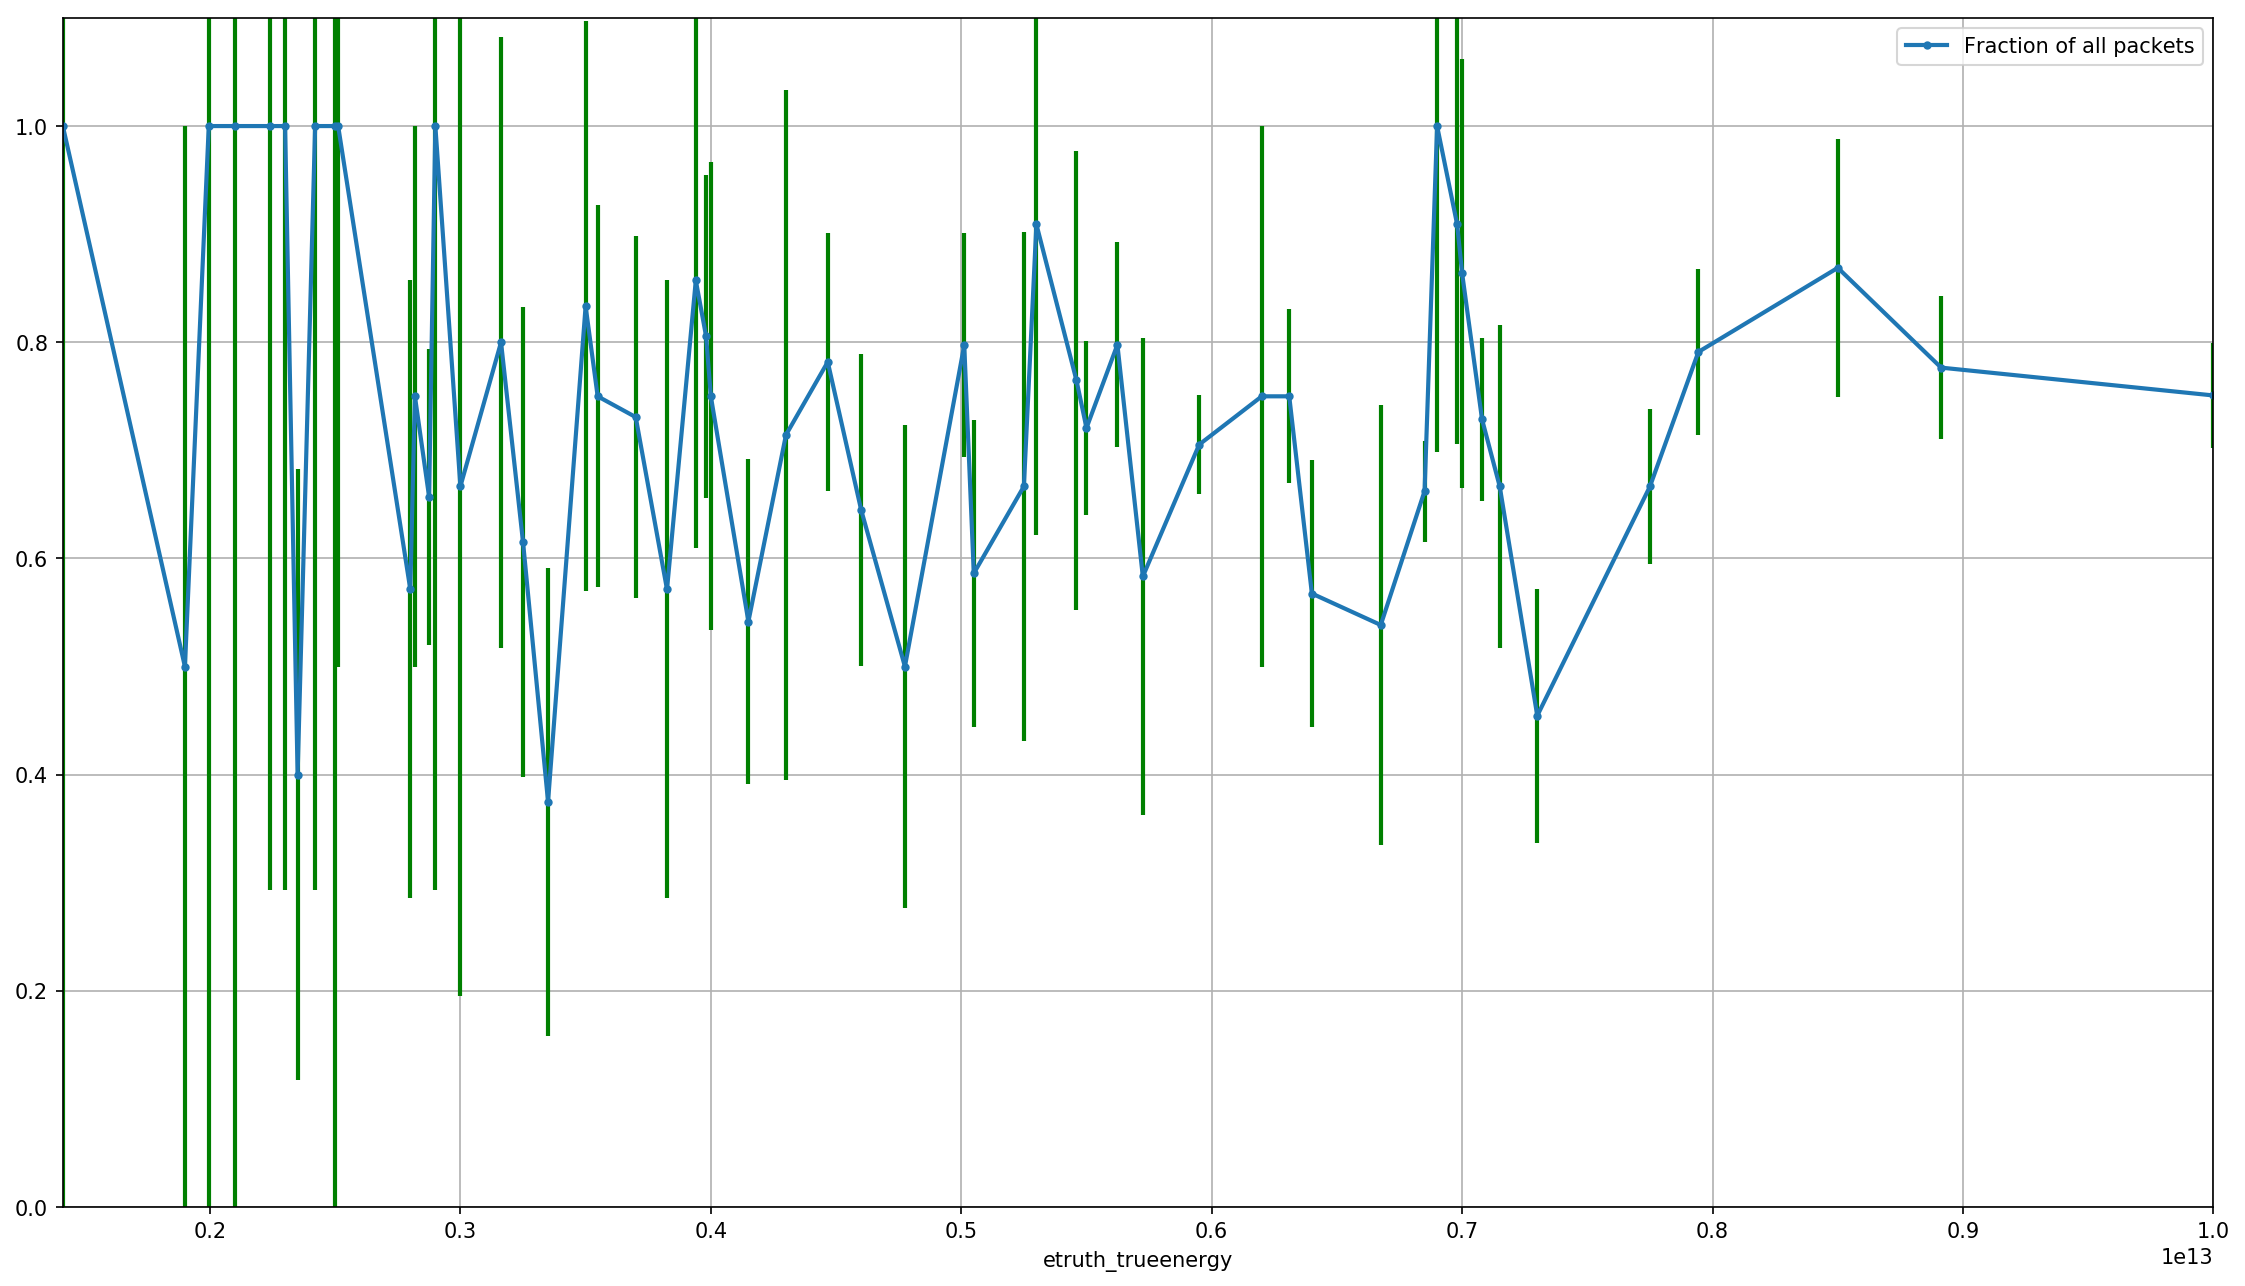

In [45]:
fig, ax = plt.subplots(1)
fig.set_size_inches(18.5, 10.5)
ax = t_cond_bgf05_simu_events_by_energy_merged_nona.plot(x='etruth_trueenergy', y='count_fraction', yerr=yerrs, marker='.',linestyle='-', ecolor='green', linewidth=2, label='Fraction of all packets', ax=ax)
ax.set_ylim([0,1.1])
ax.grid(True)


plt.show()
# plt.errorbar(t_cond_bgf05_simu_events_by_energy_merged_nona['etruth_trueenergy'], 
#              t_cond_bgf05_simu_events_by_energy_merged_nona['count_fraction'], yerr=yerrs, marker='.',linestyle='-', ecolor='green', linewidth=1)
# plt.show()

In [80]:
x = t_cond_bgf05_simu_events_by_energy_merged_nona['etruth_trueenergy']
y = t_cond_bgf05_simu_events_by_energy_merged_nona['count_fraction']
#yerrs
w = 1 - np.array(yerrs)

z1 = np.polyfit(x,y, 1, w=w)
p1 = np.poly1d(z1)

z2 = np.polyfit(x,y, 2, w=w)
p2 = np.poly1d(z2)

z3 = np.polyfit(x,y, 3, w=w)
p3 = np.poly1d(z3)

z4 = np.polyfit(x,y, 4, w=w)
p4 = np.poly1d(z4)

z8 = np.polyfit(x,y, 8, w=w)
p8 = np.poly1d(z8)

#p1(x),p2(x),p3(x)


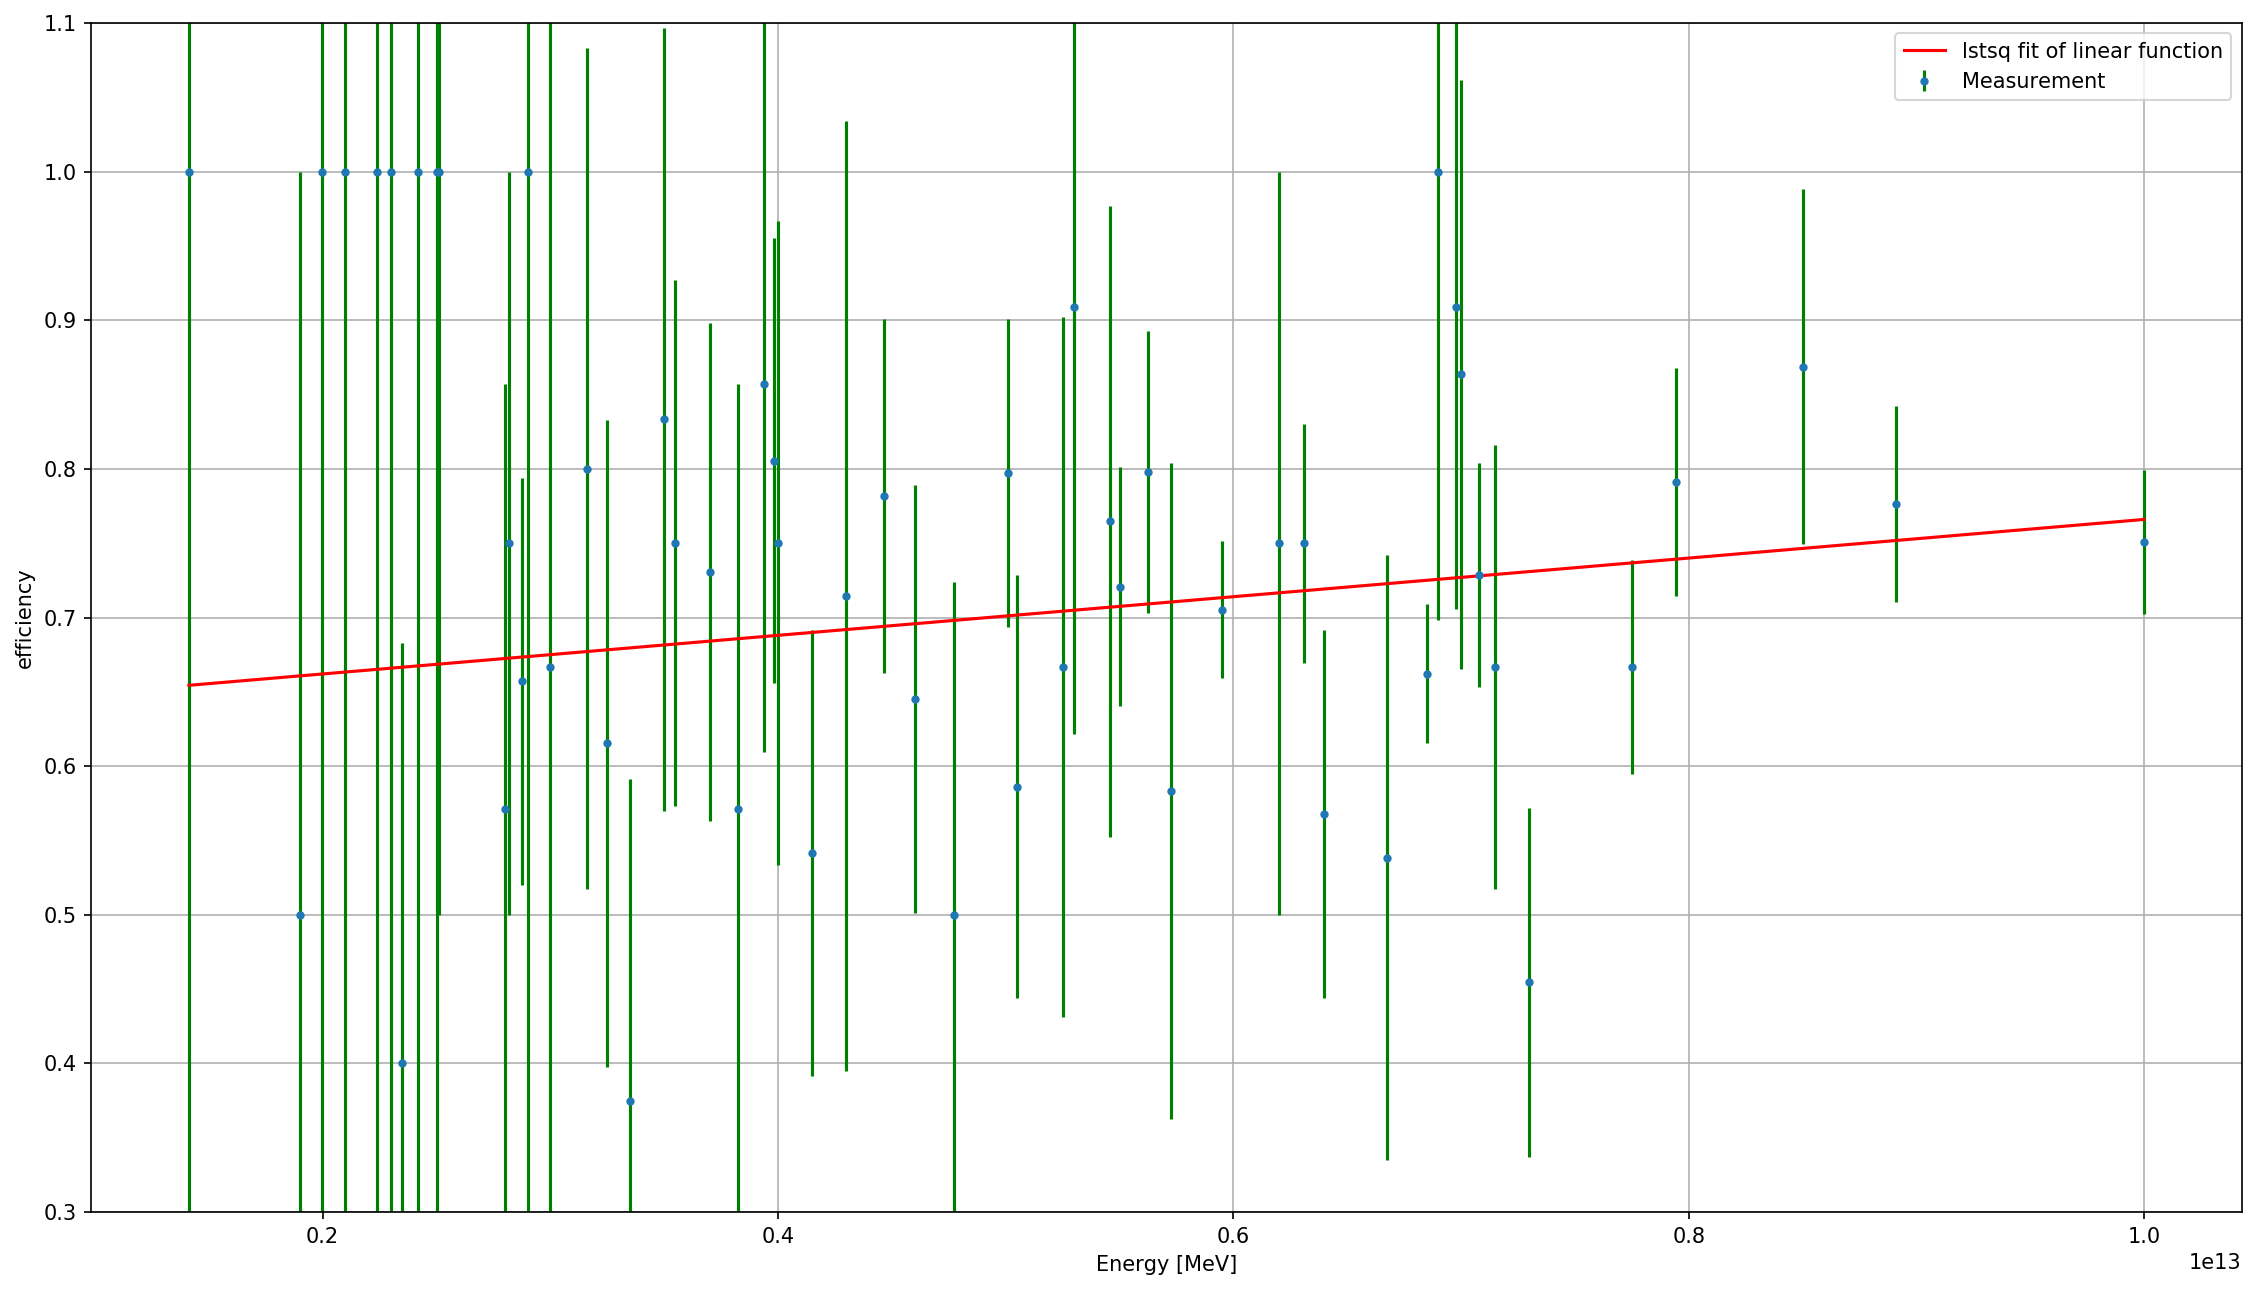

In [88]:
xv = np.linspace(np.min(x),np.max(x),100)

fig, eax = plt.subplots(1)
fig.set_size_inches(18.5, 10.5)
eax.errorbar(x,y,yerr=yerrs,ecolor='g',fmt='.',label="Measurement")

# eax.plot(xv, p1(xv),'-',color='pink',label='1st order poly')
# eax.plot(xv, p2(xv),'-',color='purple',label='2nd order poly')
# eax.plot(xv, p3(xv),'-',color='red',label='3rd order poly')
# eax.plot(xv, p4(xv),'-',color='black',label='4th order poly')
# eax.plot(xv, p8(xv),'-',color='yellow',label='8th order poly')

eax.plot(xv, p1(xv),'-',color='red',label='lstsq fit of linear function')
eax.set_ylim([0.3,1.1])
eax.grid(True)
eax.set_ylabel('efficiency')
eax.set_xlabel('Energy [MeV]')
eax.legend()
plt.show()

In [14]:
# simu2npy_pathanme_glob = "/home/eusobg/EUSO-SPB/SPBDATA_processed/spb_simu/posz_18000000/namefiles18000000.0A6.19999972557e+12E.txt/simu.2017-07-22-04h32m23s/simu2npy/ev_12_*signals.npy"
# simu2npy_pathanme = glob.glob(simu2npy_pathanme_glob)
# ev_frames = np.load(simu2npy_pathanme[0])
# npy_vis.visualize_frame(np.maximum.reduce(ev_frames))